In [2]:
from utils.graphs import discretenoise_adj_neigh, create_adjacency_mask
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import math
import logging
import time
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
import wandb
from dataset.extract_graph import get_dataloader, get_dataloader_adj
from dataset.extract_graph import vector_to_graph, vector_to_upper_triangular, upper_triangular_to_vector, graph_from_adjacency_matrix, visualize_graph, visualize_graph_from_vector, visualize_batch_from_dataloader
from model.model2 import Powerful
from utils.graphs import discretenoise, loss_func_bce, upper_flatten_to_adj_matrix, adj_matrix_to_upper_flatten, discretenoise_adj, draw_maze_from_matrix, post_process_graph, draw_maze_before_after, gen_init_data, create_adjacency_mask


width, height = 4, 4
batch_size = 1  
grid_shape = (width, height)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def sample_ppgn_simple(noise_num):
        
    model = Powerful(
        use_norm_layers=False,
        name='ppgn',
        channel_num_list=[],
        feature_nums=[],
        gnn_hidden_num_list=[],
        num_layers=6,
        input_features=2,
        hidden=64,
        hidden_final=64,
        dropout_p=0.000001,
        simplified=False,
        n_nodes=25,
        device=device,
        normalization="instance",
        cat_output=True,
        adj_out=True,
        output_features=1,
        residual=False,
        project_first=False,
        node_out=False,
        noise_mlp=False
    ).to(device)

    model.load_state_dict(torch.load('models_ppgn/best_model_adj_neigh_cycle_conn_4.pth', map_location=device))
    model.eval()

    test_batch_size = 1
    
    

    sigma_tens = torch.linspace(0, 1/2, noise_num)
    sigma_list = sigma_tens.tolist()
    sigma_list.sort()
    sigma_list = torch.tensor(sigma_list, dtype=torch.float32).to(device)

    def add_bernoulli( init_adjs, noiselevel):
        init_adjs, noise = discretenoise_adj_neigh(init_adjs, noiselevel, device, grid_shape)

        return init_adjs

    def take_step(noise_func, init_adjs, noiselevel):
        init_adjs = add_bernoulli( init_adjs, noiselevel)
        mask = torch.ones_like(init_adjs)
        noise_unnormal = noise_func(A=init_adjs.to(device), feat=None, mask=mask.to(device), noise=noiselevel)
        noise_unnormal = noise_unnormal.squeeze(-1)
        noise_rel = torch.sigmoid(noise_unnormal)
        noise_rel = (noise_rel + noise_rel.transpose(-1, -2)) / 2
        noise = torch.bernoulli(noise_rel) * mask
        adjacency_mask = create_adjacency_mask(grid_shape)
        adjacency_mask = torch.tensor(adjacency_mask, dtype=torch.float32).to(device)
        inter_adjs = torch.where(noise > 1/2, init_adjs - 1, init_adjs)
        new_adjs = torch.where(inter_adjs < -1/2, inter_adjs + 2, inter_adjs)
        new_adjs *= adjacency_mask
        return init_adjs, new_adjs

    def run_sample(eval_len=10, methods=None):
        gen_graph_list = []
        time_list = np.array([])
        change_list = np.array([])
        with torch.no_grad():
            while len(gen_graph_list)<eval_len:
                count=0
                init_adjs= gen_init_data(test_batch_size,grid_shape, device)
                mult_stages_noise = []
                mult_stages = [init_adjs.detach().cpu().numpy()]
                while count<len(sigma_list):
                    noiselevel=sigma_list[len(sigma_list)-count-1]
                    noisy_adjs,init_adjs=take_step(lambda feat, A, mask, noise: model(feat, A, mask, noise), init_adjs=init_adjs, noiselevel=noiselevel)
                    count=count+1
                    mult_stages_noise.append(noisy_adjs.detach().cpu().numpy())
                    mult_stages.append(init_adjs.detach().cpu().numpy())
                time, change = draw_maze_before_after(init_adjs.detach().cpu().numpy()[0], width, height, grid_shape, draw=False)
                time_list = np.append(time_list, time)
                change_list = np.append(change_list, change)
                gen_graph_list.append(init_adjs)
        return time_list.mean(), change_list.mean()

    result_dict = run_sample(100)

    return result_dict


sample_ppgn_simple(64)

(0.0020348286628723146, 2.61)

In [12]:


from utils.graphs import create_adjacency_mask, gen_init_data, post_process_graph


width, height = 4,4
grid_shape = (width, height)
adj_matrix = gen_init_data(1000, grid_shape, device)
count = []
time = []
counter = 0
ex_time = 0 
for k in range(100):
    post_adj_matrix, counter, ex_time = post_process_graph(adj_matrix[k].numpy(), grid_shape)
    count.append(counter)
    time.append(ex_time)

print(np.array(count).mean())
print(np.array(time).mean())




0.002060830593109131
6.99


In [8]:


from utils.graphs import discretenoise_adj_neigh, create_adjacency_mask
##function for printing the intermediate noiselevels to jupyter
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import math
import logging
import time
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
import wandb
from dataset.extract_graph import get_dataloader, get_dataloader_adj
from dataset.extract_graph import vector_to_graph, vector_to_upper_triangular, upper_triangular_to_vector, graph_from_adjacency_matrix, visualize_graph, visualize_graph_from_vector, visualize_batch_from_dataloader
from model.model2 import Powerful
from utils.graphs import discretenoise, loss_func_bce, upper_flatten_to_adj_matrix, adj_matrix_to_upper_flatten, discretenoise_adj, draw_maze_from_matrix, post_process_graph, draw_maze_before_after, gen_init_data, create_adjacency_mask
##function for printing the intermediate noiselevels to jupyter



width, height = 5,5
batch_size = 1  
grid_shape = (width, height)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def sample_ppgn_simple(noise_num):
        
    model = Powerful(
        use_norm_layers=False,
        name='ppgn',
        channel_num_list=[],
        feature_nums=[],
        gnn_hidden_num_list=[],
        num_layers=6,
        input_features=2,
        hidden=64,
        hidden_final=64,
        dropout_p=0.000001,
        simplified=False,
        n_nodes=25,
        device=device,
        normalization="instance",
        cat_output=True,
        adj_out=True,
        output_features=1,
        residual=False,
        project_first=False,
        node_out=False,
        noise_mlp=False
    ).to(device)

    model.load_state_dict(torch.load('models_ppgn/best_model_adj_neigh_cycle_conn_5.pth', map_location=device))
    model.eval()

    test_batch_size = 1
    
    

    sigma_tens = torch.linspace(0, 1/2, noise_num)
    sigma_list = sigma_tens.tolist()
    sigma_list.sort()
    sigma_list = torch.tensor(sigma_list, dtype=torch.float32).to(device)

    def add_bernoulli( init_adjs, noiselevel):
        init_adjs, noise = discretenoise_adj_neigh(init_adjs, noiselevel, device, grid_shape)

        return init_adjs

    def take_step(noise_func, init_adjs, noiselevel):
        init_adjs = add_bernoulli( init_adjs, noiselevel)
        mask = torch.ones_like(init_adjs)
        noise_unnormal = noise_func(A=init_adjs.to(device), feat=None, mask=mask.to(device), noise=noiselevel)
        noise_unnormal = noise_unnormal.squeeze(-1)
        noise_rel = torch.sigmoid(noise_unnormal)
        noise_rel = (noise_rel + noise_rel.transpose(-1, -2)) / 2
        noise = torch.bernoulli(noise_rel) * mask
        adjacency_mask = create_adjacency_mask(grid_shape)
        adjacency_mask = torch.tensor(adjacency_mask, dtype=torch.float32).to(device)
        inter_adjs = torch.where(noise > 1/2, init_adjs - 1, init_adjs)
        new_adjs = torch.where(inter_adjs < -1/2, inter_adjs + 2, inter_adjs)
        new_adjs *= adjacency_mask
        return init_adjs, new_adjs

    def run_sample(eval_len=10, methods=None):
        gen_graph_list = []
        time_list = np.array([])
        change_list = np.array([])
        with torch.no_grad():
            while len(gen_graph_list)<eval_len:
                count=0
                init_adjs= gen_init_data(test_batch_size,grid_shape, device)
                mult_stages_noise = []
                mult_stages = [init_adjs.detach().cpu().numpy()]
                while count<len(sigma_list):
                    noiselevel=sigma_list[len(sigma_list)-count-1]
                    noisy_adjs,init_adjs=take_step(lambda feat, A, mask, noise: model(feat, A, mask, noise), init_adjs=init_adjs, noiselevel=noiselevel)
                    count=count+1
                    mult_stages_noise.append(noisy_adjs.detach().cpu().numpy())
                    mult_stages.append(init_adjs.detach().cpu().numpy())
                time, change = draw_maze_before_after(init_adjs.detach().cpu().numpy()[0], width, height, grid_shape, draw=False)
                time_list = np.append(time_list, time)
                change_list = np.append(change_list, change)
                gen_graph_list.append(init_adjs)
        return time_list.mean(), change_list.mean()

    result_dict = run_sample(100)

    return result_dict


sample_ppgn_simple(64)

(0.006026816368103027, 6.62)

In [4]:
width, height = 5,5
grid_shape = (width, height)
adj_matrix = gen_init_data(1000, grid_shape, device)
count = []
time = []
counter = 0
ex_time = 0 
for k in range(1000):
    post_adj_matrix, counter, ex_time = post_process_graph(adj_matrix[k].numpy(), grid_shape)
    count.append(counter)
    time.append(ex_time)

print(np.array(count).mean())
print(np.array(time).mean())


0.005985126495361328
11.797


In [9]:


from utils.graphs import discretenoise_adj_neigh, create_adjacency_mask
##function for printing the intermediate noiselevels to jupyter
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import math
import logging
import time
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
import wandb
from dataset.extract_graph import get_dataloader, get_dataloader_adj
from dataset.extract_graph import vector_to_graph, vector_to_upper_triangular, upper_triangular_to_vector, graph_from_adjacency_matrix, visualize_graph, visualize_graph_from_vector, visualize_batch_from_dataloader
from model.model2 import Powerful
from utils.graphs import discretenoise, loss_func_bce, upper_flatten_to_adj_matrix, adj_matrix_to_upper_flatten, discretenoise_adj, draw_maze_from_matrix, post_process_graph, draw_maze_before_after, gen_init_data, create_adjacency_mask
##function for printing the intermediate noiselevels to jupyter



width, height = 6,6
batch_size = 1  
grid_shape = (width, height)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def sample_ppgn_simple(noise_num):
        
    model = Powerful(
        use_norm_layers=False,
        name='ppgn',
        channel_num_list=[],
        feature_nums=[],
        gnn_hidden_num_list=[],
        num_layers=6,
        input_features=2,
        hidden=64,
        hidden_final=64,
        dropout_p=0.000001,
        simplified=False,
        n_nodes=width*height,
        device=device,
        normalization="instance",
        cat_output=True,
        adj_out=True,
        output_features=1,
        residual=False,
        project_first=False,
        node_out=False,
        noise_mlp=False
    ).to(device)

    model.load_state_dict(torch.load('models_ppgn/best_model_adj_neigh_cycle_conn_6.pth', map_location=device))
    model.eval()

    test_batch_size = 1
    

    sigma_tens = torch.linspace(0, 1/2, noise_num)
    sigma_list = sigma_tens.tolist()
    sigma_list.sort()
    sigma_list = torch.tensor(sigma_list, dtype=torch.float32).to(device)

    def add_bernoulli( init_adjs, noiselevel):
        init_adjs, noise = discretenoise_adj_neigh(init_adjs, noiselevel, device, grid_shape)

        return init_adjs

    def take_step(noise_func, init_adjs, noiselevel):
        init_adjs = add_bernoulli( init_adjs, noiselevel)
        mask = torch.ones_like(init_adjs)
        noise_unnormal = noise_func(A=init_adjs.to(device), feat=None, mask=mask.to(device), noise=noiselevel)
        noise_unnormal = noise_unnormal.squeeze(-1)
        noise_rel = torch.sigmoid(noise_unnormal)
        noise_rel = (noise_rel + noise_rel.transpose(-1, -2)) / 2
        noise = torch.bernoulli(noise_rel) * mask
        adjacency_mask = create_adjacency_mask(grid_shape)
        adjacency_mask = torch.tensor(adjacency_mask, dtype=torch.float32).to(device)
        inter_adjs = torch.where(noise > 1/2, init_adjs - 1, init_adjs)
        new_adjs = torch.where(inter_adjs < -1/2, inter_adjs + 2, inter_adjs)
        new_adjs *= adjacency_mask
        return init_adjs, new_adjs

    def run_sample(eval_len=10, methods=None):
        gen_graph_list = []
        time_list = np.array([])
        change_list = np.array([])
        with torch.no_grad():
            while len(gen_graph_list)<eval_len:
                count=0
                init_adjs= gen_init_data(test_batch_size,grid_shape, device)
                mult_stages_noise = []
                mult_stages = [init_adjs.detach().cpu().numpy()]
                while count<len(sigma_list):
                    noiselevel=sigma_list[len(sigma_list)-count-1]
                    noisy_adjs,init_adjs=take_step(lambda feat, A, mask, noise: model(feat, A, mask, noise), init_adjs=init_adjs, noiselevel=noiselevel)
                    count=count+1
                    mult_stages_noise.append(noisy_adjs.detach().cpu().numpy())
                    mult_stages.append(init_adjs.detach().cpu().numpy())
                time, change = draw_maze_before_after(init_adjs.detach().cpu().numpy()[0], width, height, grid_shape, draw=False)
                time_list = np.append(time_list, time)
                change_list = np.append(change_list, change)
                gen_graph_list.append(init_adjs)
        return time_list.mean(), change_list.mean()

    result_dict = run_sample(100)

    return result_dict


sample_ppgn_simple(64)

(0.016746928691864015, 10.75)

In [4]:
width, height = 6,6
grid_shape = (width, height)
adj_matrix = gen_init_data(1000, grid_shape, device)
count = []
time = []
counter = 0
ex_time = 0 
for k in range(100):
    post_adj_matrix, counter, ex_time = post_process_graph(adj_matrix[k].numpy(), grid_shape)
    count.append(counter)
    time.append(ex_time)

print(np.array(count).mean())
print(np.array(time).mean())


0.014373576641082764
18.95


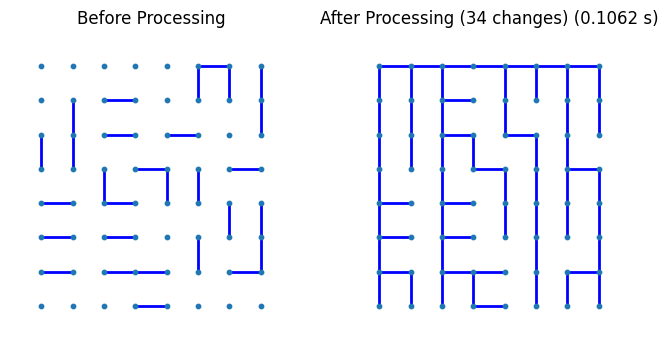

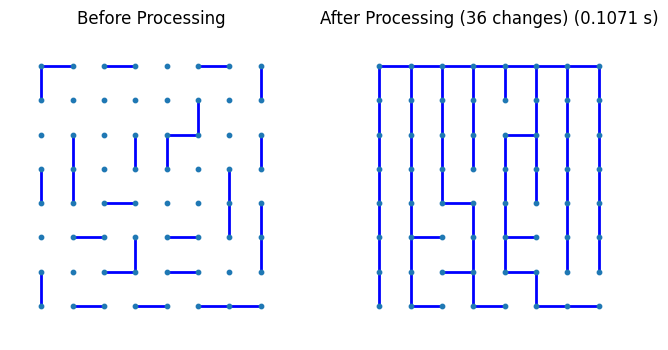

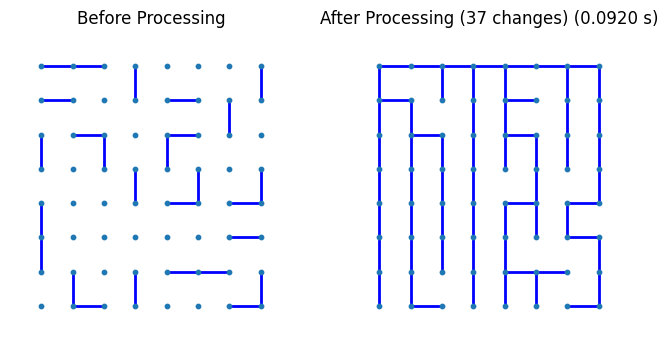

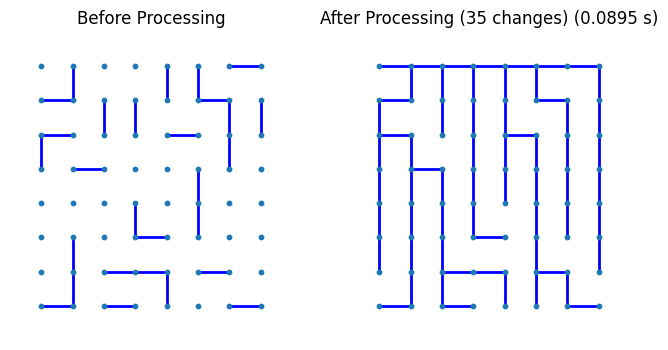

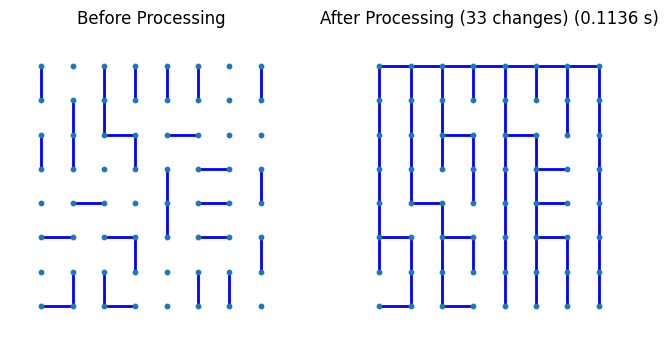

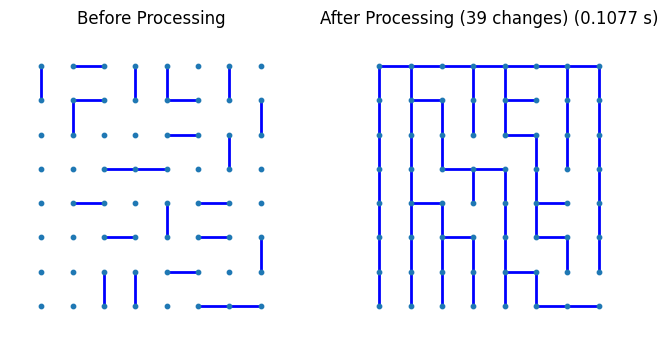

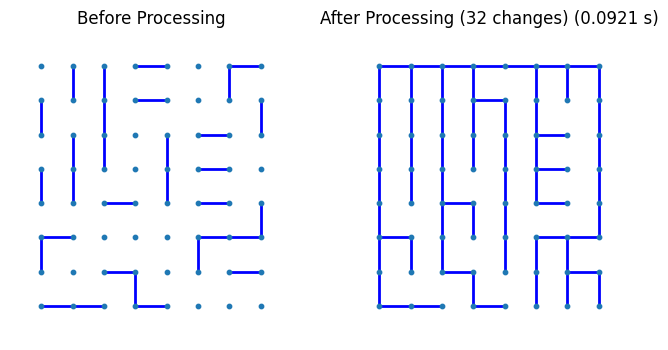

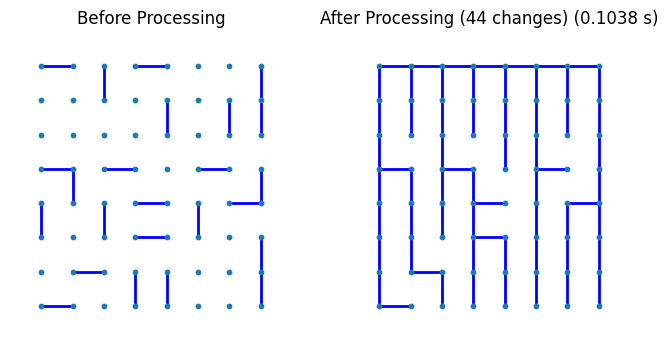

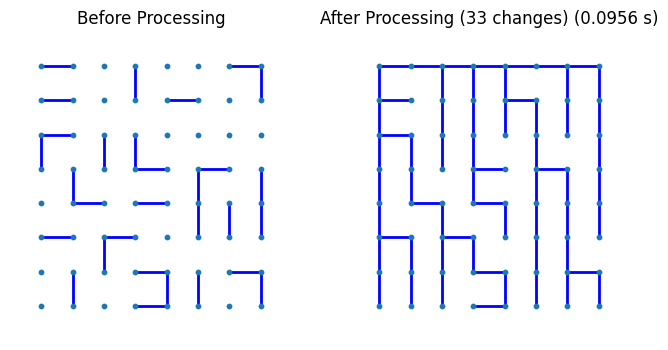

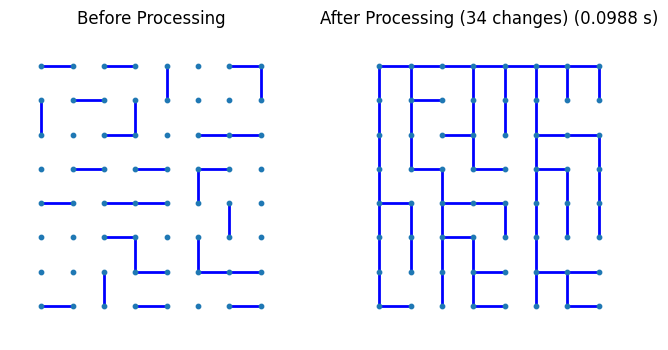

(0.10064060688018799, 35.7)

In [7]:


from utils.graphs import discretenoise_adj_neigh, create_adjacency_mask
##function for printing the intermediate noiselevels to jupyter
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import math
import logging
import time
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
import wandb
from dataset.extract_graph import get_dataloader, get_dataloader_adj
from dataset.extract_graph import vector_to_graph, vector_to_upper_triangular, upper_triangular_to_vector, graph_from_adjacency_matrix, visualize_graph, visualize_graph_from_vector, visualize_batch_from_dataloader
from model.model2 import Powerful
from utils.graphs import discretenoise, loss_func_bce, upper_flatten_to_adj_matrix, adj_matrix_to_upper_flatten, discretenoise_adj, draw_maze_from_matrix, post_process_graph, draw_maze_before_after, gen_init_data, create_adjacency_mask
##function for printing the intermediate noiselevels to jupyter



width, height = 8,8
batch_size = 1  
grid_shape = (width, height)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def sample_ppgn_simple(noise_num):
        
    model = Powerful(
        use_norm_layers=False,
        name='ppgn',
        channel_num_list=[],
        feature_nums=[],
        gnn_hidden_num_list=[],
        num_layers=6,
        input_features=2,
        hidden=64,
        hidden_final=64,
        dropout_p=0.000001,
        simplified=False,
        n_nodes=width*height,
        device=device,
        normalization="instance",
        cat_output=True,
        adj_out=True,
        output_features=1,
        residual=False,
        project_first=False,
        node_out=False,
        noise_mlp=False
    ).to(device)

    model.load_state_dict(torch.load('models_ppgn/best_model_adj_neigh_8.pth', map_location=device))
    model.eval()

    test_batch_size = 1
    

    sigma_tens = torch.linspace(0, 1/2, noise_num)
    sigma_list = sigma_tens.tolist()
    sigma_list.sort()
    sigma_list = torch.tensor(sigma_list, dtype=torch.float32).to(device)

    def add_bernoulli( init_adjs, noiselevel):
        init_adjs, noise = discretenoise_adj_neigh(init_adjs, noiselevel, device, grid_shape)

        return init_adjs

    def take_step(noise_func, init_adjs, noiselevel):
        init_adjs = add_bernoulli( init_adjs, noiselevel)
        mask = torch.ones_like(init_adjs)
        noise_unnormal = noise_func(A=init_adjs.to(device), feat=None, mask=mask.to(device), noise=noiselevel)
        noise_unnormal = noise_unnormal.squeeze(-1)
        noise_rel = torch.sigmoid(noise_unnormal)
        noise_rel = (noise_rel + noise_rel.transpose(-1, -2)) / 2
        noise = torch.bernoulli(noise_rel) * mask
        adjacency_mask = create_adjacency_mask(grid_shape)
        adjacency_mask = torch.tensor(adjacency_mask, dtype=torch.float32).to(device)
        inter_adjs = torch.where(noise > 1/2, init_adjs - 1, init_adjs)
        new_adjs = torch.where(inter_adjs < -1/2, inter_adjs + 2, inter_adjs)
        new_adjs *= adjacency_mask
        return init_adjs, new_adjs

    def run_sample(eval_len=10, methods=None):
        gen_graph_list = []
        time_list = np.array([])
        change_list = np.array([])
        with torch.no_grad():
            while len(gen_graph_list)<eval_len:
                count=0
                init_adjs= gen_init_data(test_batch_size,grid_shape, device)
                mult_stages_noise = []
                mult_stages = [init_adjs.detach().cpu().numpy()]
                while count<len(sigma_list):
                    noiselevel=sigma_list[len(sigma_list)-count-1]
                    noisy_adjs,init_adjs=take_step(lambda feat, A, mask, noise: model(feat, A, mask, noise), init_adjs=init_adjs, noiselevel=noiselevel)
                    count=count+1
                    mult_stages_noise.append(noisy_adjs.detach().cpu().numpy())
                    mult_stages.append(init_adjs.detach().cpu().numpy())
                time, change = draw_maze_before_after(init_adjs.detach().cpu().numpy()[0], width, height, grid_shape)
                time_list = np.append(time_list, time)
                change_list = np.append(change_list, change)
                gen_graph_list.append(init_adjs)
        return time_list.mean(), change_list.mean()

    result_dict = run_sample(10)

    return result_dict


sample_ppgn_simple(64)

In [3]:
width, height = 8,8
grid_shape = (width, height)
adj_matrix = gen_init_data(1000, grid_shape, device)
count = []
time = []
counter = 0
ex_time = 0 
for k in range(100):
    post_adj_matrix, counter, ex_time = post_process_graph(adj_matrix[k].numpy(), grid_shape)
    count.append(counter)
    time.append(ex_time)

print(np.array(count).mean())
print(np.array(time).mean())


0.06247108936309814
37.08


In [1]:
import os 
import sys

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import math
import logging
import time

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
import wandb
from dataset.extract_graph import get_dataloader, get_dataloader_adj
from dataset.extract_graph import vector_to_graph, vector_to_upper_triangular, upper_triangular_to_vector, graph_from_adjacency_matrix, visualize_graph, visualize_graph_from_vector, visualize_batch_from_dataloader
from model.model2 import Powerful
from utils.graphs import discretenoise, loss_func_bce, upper_flatten_to_adj_matrix, adj_matrix_to_upper_flatten, discretenoise_adj, draw_maze_from_matrix
def plot_inter_graphs_jup(graphs,title,nr_to_analyze=0):
    maxnodes=0
    graphs_proces=[]
    for g in graphs:
        graphs_proces.append(nx.from_numpy_matrix(g[0]))

    torch.set_printoptions(profile="full")
    figure = plt.figure(figsize=(25, 25))
    max_num=len(graphs)
    img_c = int(np.sqrt(max_num))
    pos=nx.spring_layout(graphs_proces[-1])
    for i, sigmalevel_adjs in enumerate(graphs_proces):
        plt.figure(figsize=(25, 25))
        G = sigmalevel_adjs.copy()
        G.remove_nodes_from(list(nx.isolates(G)))
        e = G.number_of_edges()
        v = G.number_of_nodes()
        l = nx.number_of_selfloops(G)
        ax = plt.subplot(img_c+1, img_c+1, i+1)
        title_str = f'fl={"nrofnodes"},no={i}'
        nx.draw(G, pos, with_labels=False, **options)
        ax.title.set_text(title_str)
        plt.show()
        
    title=f'{title}-{nr_to_analyze}.pdf'
    figure.suptitle(title)

options = {
    'node_size': 2,
    'edge_color': 'black',
    'linewidths': 1,
    'width': 0.5
}

<Figure size 2500x2500 with 0 Axes>

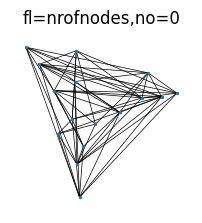

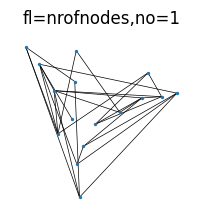

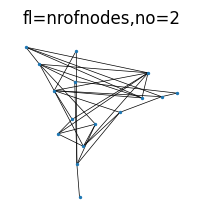

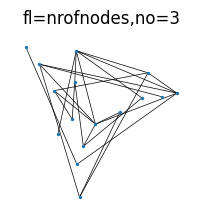

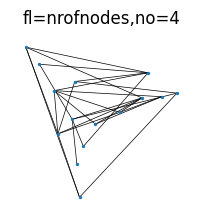

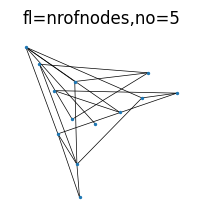

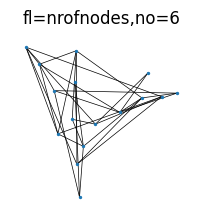

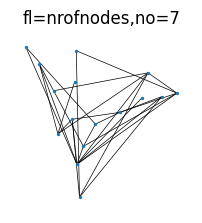

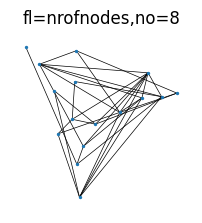

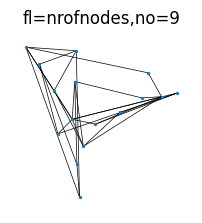

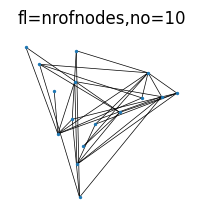

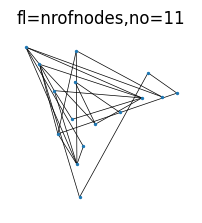

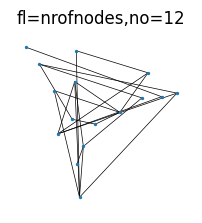

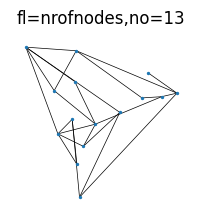

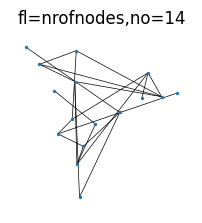

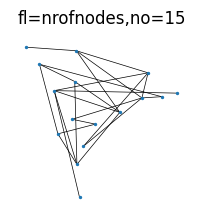

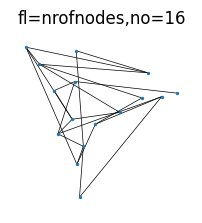

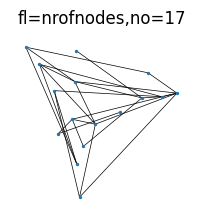

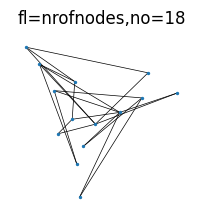

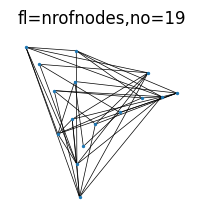

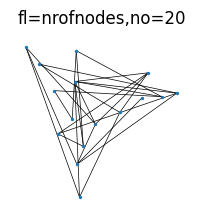

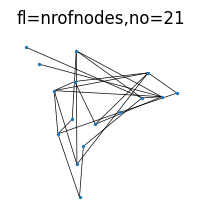

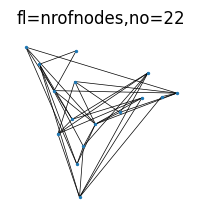

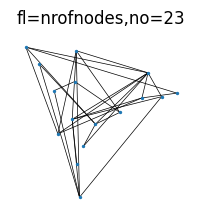

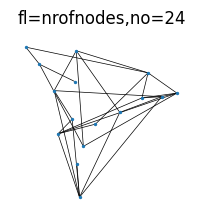

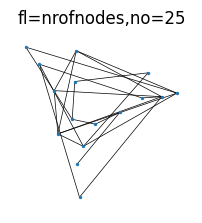

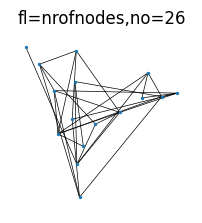

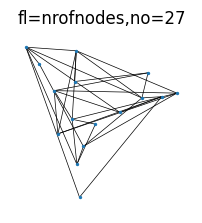

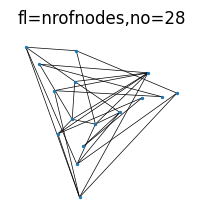

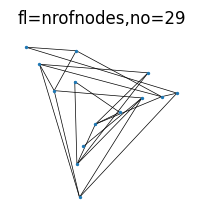

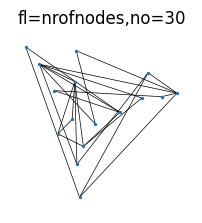

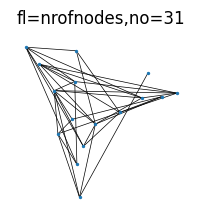

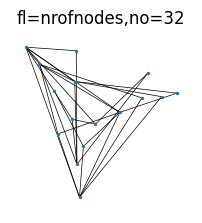

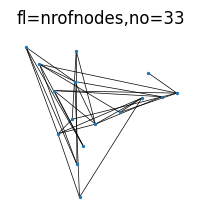

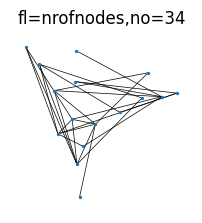

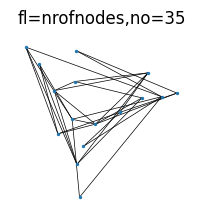

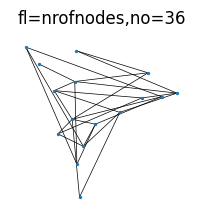

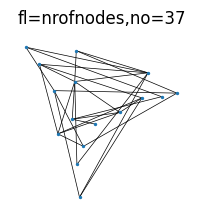

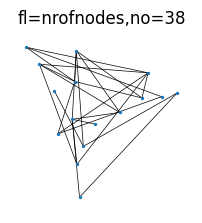

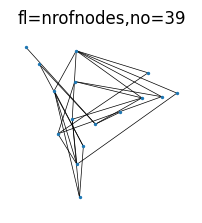

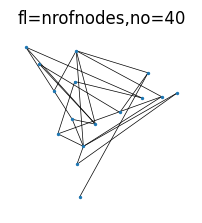

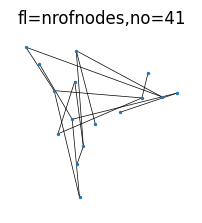

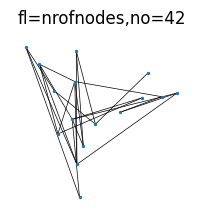

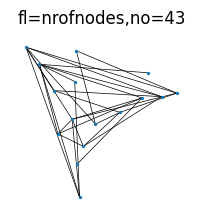

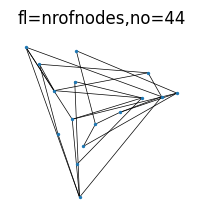

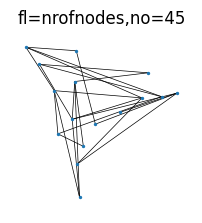

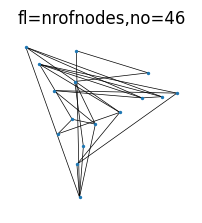

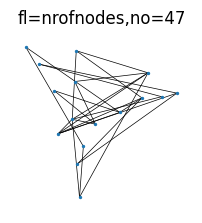

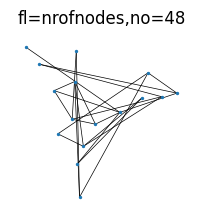

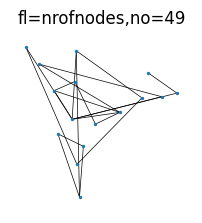

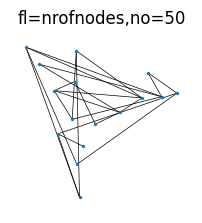

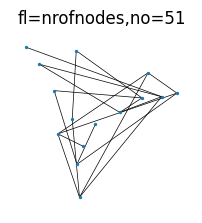

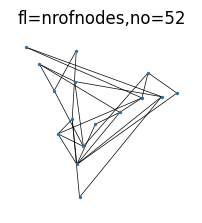

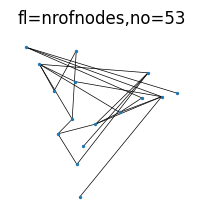

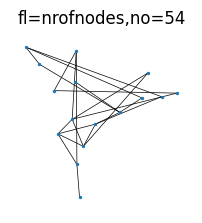

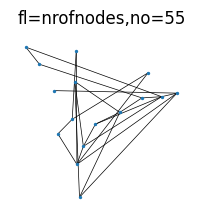

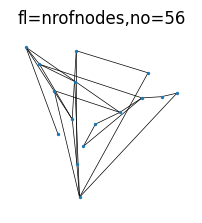

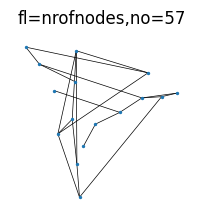

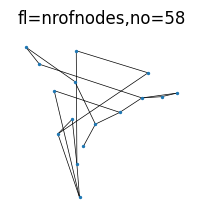

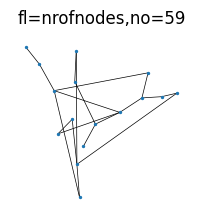

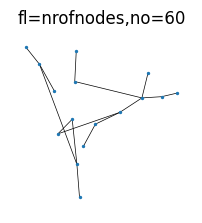

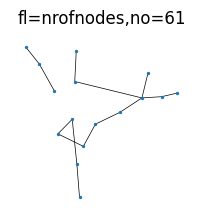

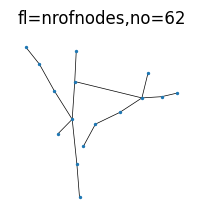

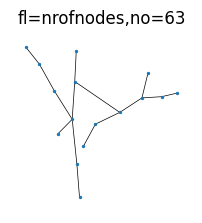

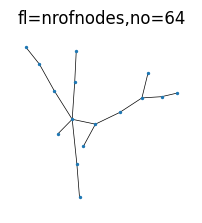

<Figure size 2500x2500 with 0 Axes>

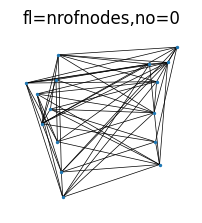

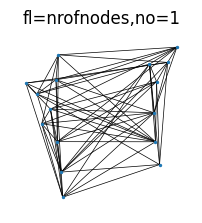

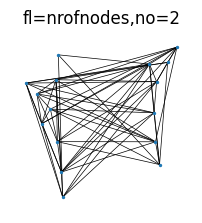

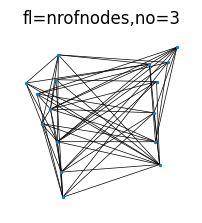

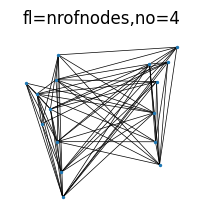

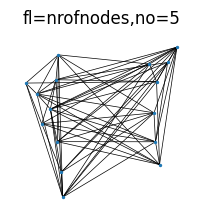

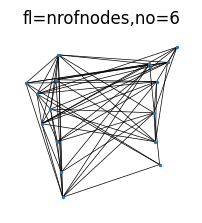

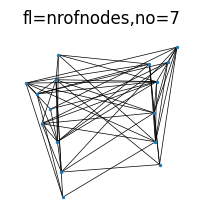

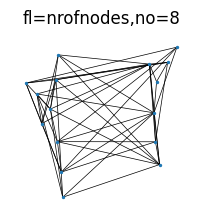

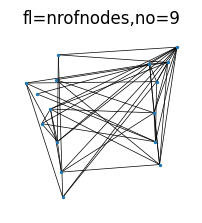

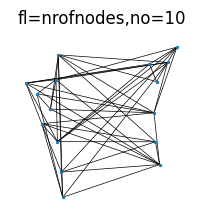

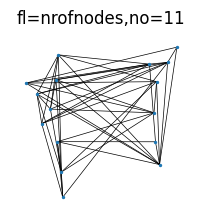

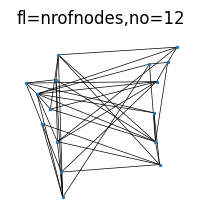

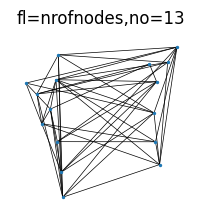

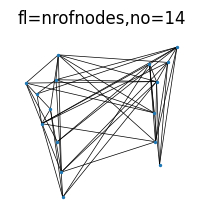

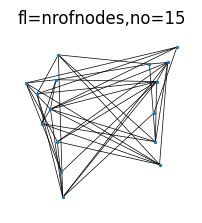

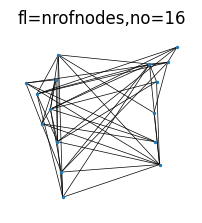

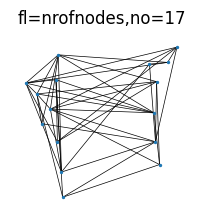

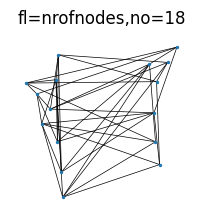

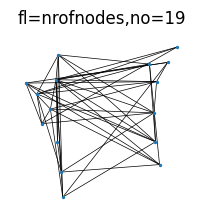

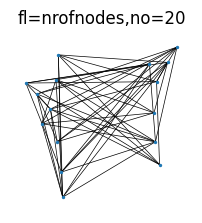

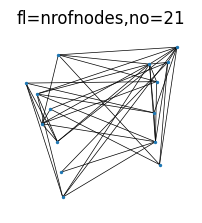

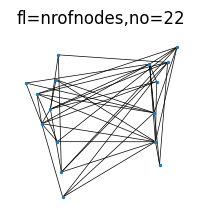

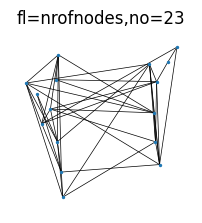

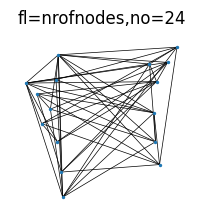

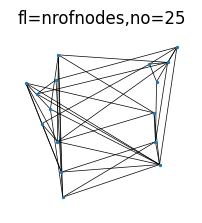

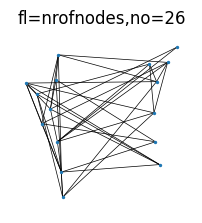

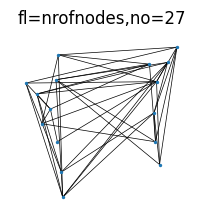

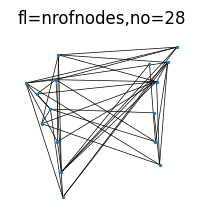

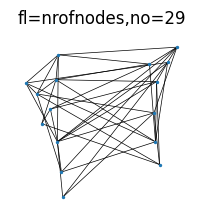

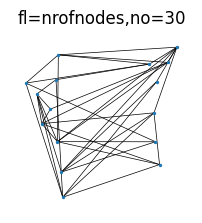

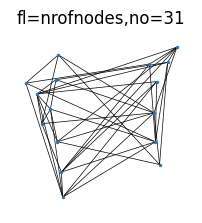

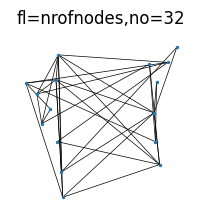

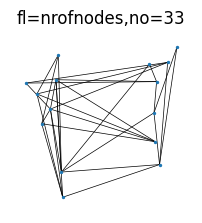

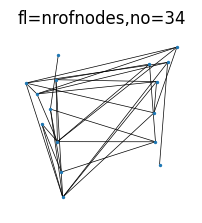

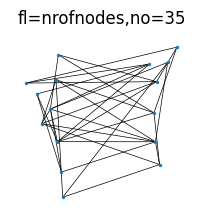

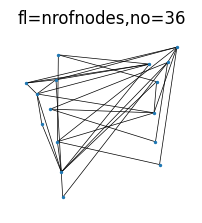

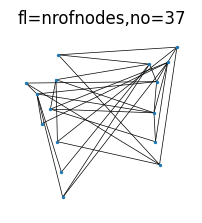

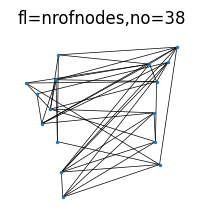

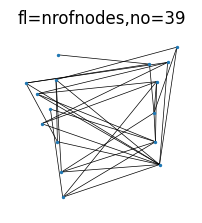

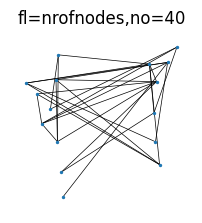

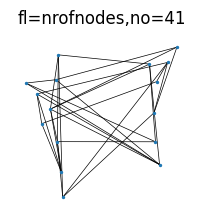

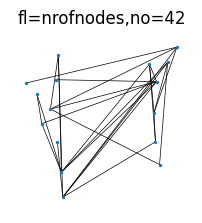

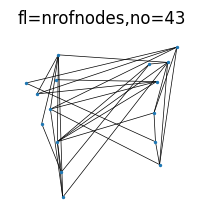

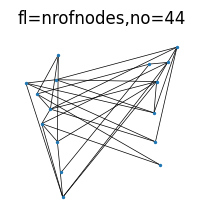

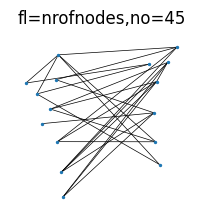

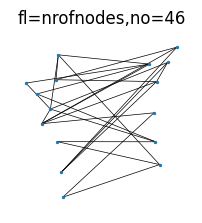

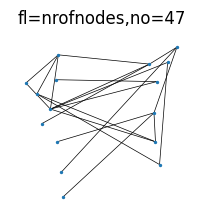

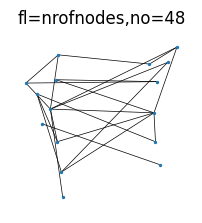

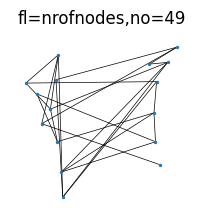

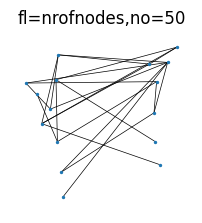

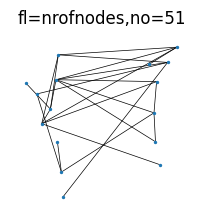

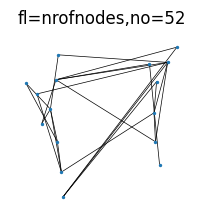

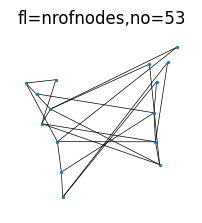

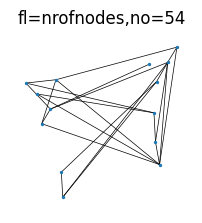

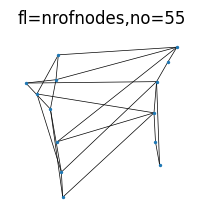

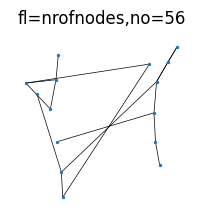

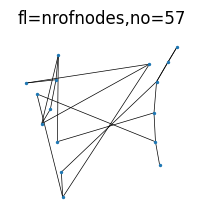

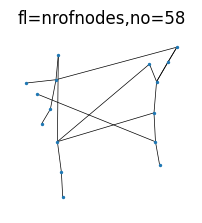

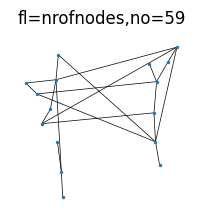

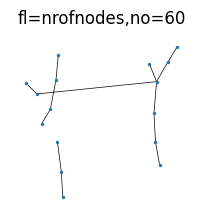

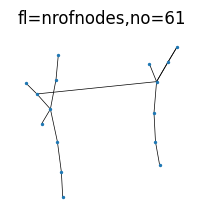

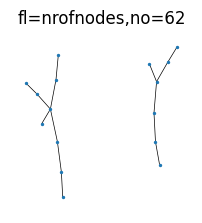

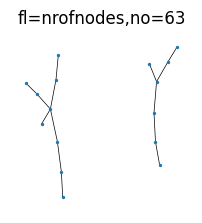

In [7]:

##function for printing the intermediate noiselevels to jupyter

def plot_inter_graphs_jup(graphs,title,nr_to_analyze=0):
    maxnodes=0
    graphs_proces=[]
    for g in graphs:
        graphs_proces.append(nx.from_numpy_matrix(g[0]))

    torch.set_printoptions(profile="full")
    figure = plt.figure(figsize=(25, 25))
    max_num=len(graphs)
    img_c = int(np.sqrt(max_num))
    pos=nx.spring_layout(graphs_proces[-1])
    for i, sigmalevel_adjs in enumerate(graphs_proces):
        plt.figure(figsize=(25, 25))
        G = sigmalevel_adjs.copy()
        G.remove_nodes_from(list(nx.isolates(G)))
        e = G.number_of_edges()
        v = G.number_of_nodes()
        l = nx.number_of_selfloops(G)
        ax = plt.subplot(img_c+1, img_c+1, i+1)
        title_str = f'fl={"nrofnodes"},no={i}'
        nx.draw(G, pos, with_labels=False, **options)
        ax.title.set_text(title_str)
        plt.show()
        
    title=f'{title}-{nr_to_analyze}.pdf'
    figure.suptitle(title)

options = {
    'node_size': 2,
    'edge_color': 'black',
    'linewidths': 1,
    'width': 0.5
}
filename = 'dataset/usts_4.pkl'
width, height = 4, 4
batch_size = 1  
dataloader = get_dataloader_adj(filename, width, height, batch_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def sample_ppgn_simple(noise_num):
    
    batch = next(iter(dataloader))
    train_graph_list = batch
    
    model = Powerful(
        use_norm_layers=False,
        name='ppgn',
        channel_num_list=[],
        feature_nums=[],
        gnn_hidden_num_list=[],
        num_layers=6,
        input_features=2,
        hidden=64,
        hidden_final=64,
        dropout_p=0.000001,
        simplified=False,
        n_nodes=25,
        device=device,
        normalization="instance",
        cat_output=True,
        adj_out=True,
        output_features=1,
        residual=False,
        project_first=False,
        node_out=False,
        noise_mlp=False
    ).to(device)

    model.load_state_dict(torch.load('trained_model_adj.pth', map_location=device))
    model.eval()
    
    max_node_number = 16
    test_batch_size = 16
    test_batch_size = 1
    
    def gen_init_data(batch_size):

        base_adjs= batch.to(device)

        bernoulli_adj = torch.zeros(batch_size, max_node_number, max_node_number).to(device)
        for k, matrix in enumerate(base_adjs):
            for i, row in enumerate(matrix):
                for j, col in enumerate(row):
                    bernoulli_adj[k, i, j] = 1/2
                        
        noise_upper = torch.bernoulli(bernoulli_adj).triu(diagonal=1)
        noise_lower = noise_upper.transpose(-1, -2)
        initialmatrix = noise_lower + noise_upper
        return initialmatrix


    sigma_tens = torch.linspace(0, 1/2, noise_num)
    sigma_list = sigma_tens.tolist()
    sigma_list.sort()
    sigma_list = torch.tensor(sigma_list, dtype=torch.float32).to(device)

    def add_bernoulli( init_adjs, noiselevel):
        init_adjs, noise = discretenoise_adj(init_adjs, noiselevel, device)

        return init_adjs

    def take_step(noise_func, init_adjs, noiselevel):
        init_adjs = add_bernoulli( init_adjs, noiselevel)
        mask = torch.ones_like(init_adjs)
        noise_unnormal = noise_func(A=init_adjs.to(device), feat=None, mask=mask.to(device), noise=noiselevel)
        noise_unnormal = noise_unnormal.squeeze(-1)
        noise_rel = torch.sigmoid(noise_unnormal)
        noise_rel = (noise_rel + noise_rel.transpose(-1, -2)) / 2
        noise = torch.bernoulli(noise_rel) * mask
        
        inter_adjs = torch.where(noise > 1/2, init_adjs - 1, init_adjs)
        new_adjs = torch.where(inter_adjs < -1/2, inter_adjs + 2, inter_adjs)
        
        return init_adjs, new_adjs

    def run_sample(eval_len=10, methods=None):
        gen_graph_list = []
        with torch.no_grad():
            while len(gen_graph_list)<eval_len:
                count=0
                init_adjs= gen_init_data(batch_size = test_batch_size)

                ##
                mult_stages_noise = []
                mult_stages = [init_adjs.detach().cpu().numpy()]
                ##

                while count<len(sigma_list):
                    noiselevel=sigma_list[len(sigma_list)-count-1]
                    noisy_adjs,init_adjs=take_step(lambda feat, A, mask, noise: model(feat, A, mask, noise), init_adjs=init_adjs, noiselevel=noiselevel)
                    count=count+1
                    mult_stages_noise.append(noisy_adjs.detach().cpu().numpy())
                    mult_stages.append(init_adjs.detach().cpu().numpy())
                # draw_maze_from_matrix(init_adjs.detach().cpu().numpy()[0], width, height, f'{count}')
                gen_graph_list.append(init_adjs.cpu().numpy())

        pic_title = f'final_sample_ipynb_{noise_num}.pdf'
        #plot_graphs_list(graphs=gen_graph_list, title=pic_title, save_dir=config.save_dir)
        plot_inter_graphs_jup(graphs=mult_stages, title='intermediate', nr_to_analyze=0)
        plot_inter_graphs_jup(graphs=mult_stages_noise, title='intermediate', nr_to_analyze=0)
    result_dict = run_sample()

    return result_dict


sample_ppgn_simple(64)